In [5]:
import sys
sys.path.insert(0, '..')

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [7]:
from iactrace import (
    Telescope, Cylinder, MCIntegrator, HexagonalSensor, SquareSensor, 
    hexshow, plot_telescope_geometry
)

# First Test of IACT raytracer:

In [9]:
n_mirrors = 30
theta = jnp.linspace(0, 6*jnp.pi, n_mirrors, endpoint=False)
radii = jnp.concatenate([
    jnp.full(10, 2.0),   # Inner ring
    jnp.full(10, 3.5),   # Middle ring
    jnp.full(10, 5.0),   # Outer ring
])
mirror_diameter = 0.6

mirror_positions = jnp.stack([
    radii * jnp.cos(theta),
    radii * jnp.sin(theta),
    jnp.full(n_mirrors, mirror_diameter)
], axis=1)

telescope = Telescope(
    mirror_positions=mirror_positions,
    focal_length=15.0,
    dish_radius=15.0,
    surface_type='spherical', 
    alignment_perturbation=0.01
)

In [10]:
telescope.add_obstruction(Cylinder(
    p1=jnp.array([0., 0., 15.]),
    p2=jnp.array([0., 0., 18.]),
    radius=1
))

def create_hex_camera(n_rings=5, pixel_size=0.042):
    """Create hexagonal camera geometry."""
    pixels = []
    for q in range(-n_rings, n_rings + 1):
        for r in range(-n_rings, n_rings + 1):
            s = -q - r
            if abs(s) <= n_rings:
                # Axial to Cartesian (flat-top)
                x = pixel_size * (3./2 * q)
                y = pixel_size * (np.sqrt(3)/2 * q + np.sqrt(3) * r)
                pixels.append([x, y])
    return np.array(pixels)

hex_centers = create_hex_camera(n_rings=20, pixel_size=0.0042)

In [11]:
integrator = MCIntegrator(n_samples=64, roughness=10.0)
#sensor = HexagonalSensor(hex_centers=hex_centers)
sensor = SquareSensor(100,100)

In [12]:
print("Compiling simulation...")
sim = telescope.compile(
    integrator=integrator,
    sensor=sensor,
    source_type='infinity',
    sensor_plane=(jnp.array([0., 0., 15.]), jnp.array([0., 0., -1.])),
    sampling_key=jax.random.key(42),
    alignment_key=jax.random.key(11)
)

print("Simulation compiled!")

Compiling simulation...
Simulation compiled!


# Simulating Stars:

In [13]:
# Generate star field
n_stars = 100000
key = jax.random.key(143)
key1, key2 = jax.random.split(key)

# Small angular region (5 degrees field of view)
fov_deg = 5
fov_rad = fov_deg * jnp.pi / 180

x = jax.random.uniform(key1, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
y = jax.random.uniform(key2, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
z = -jnp.ones(n_stars)

stars = jnp.stack([x, y, z], axis=1)
stars = stars / jnp.linalg.norm(stars, axis=1, keepdims=True)


In [23]:
%%time
result = sim(stars, 'infinity').block_until_ready()

CPU times: user 2.84 ms, sys: 973 µs, total: 3.82 ms
Wall time: 483 ms


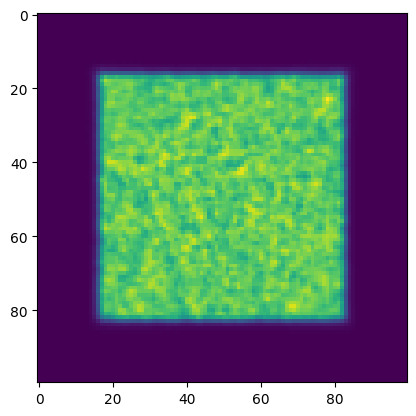

In [26]:
plt.imshow(result)

# Simulating points:

In [20]:
N_points = 100

key = jax.random.key(12)
key1, key2 = jax.random.split(key)

x = jax.random.uniform(key1, N_points, minval=-1, maxval=1)
y = jax.random.uniform(key2, N_points, minval=-1, maxval=1)
z = jnp.ones(N_points) * 120

points = jnp.array([x,y,z]).T

In [23]:
%%time
result = sim(points, 'point').block_until_ready()

CPU times: user 910 µs, sys: 890 µs, total: 1.8 ms
Wall time: 1.15 ms


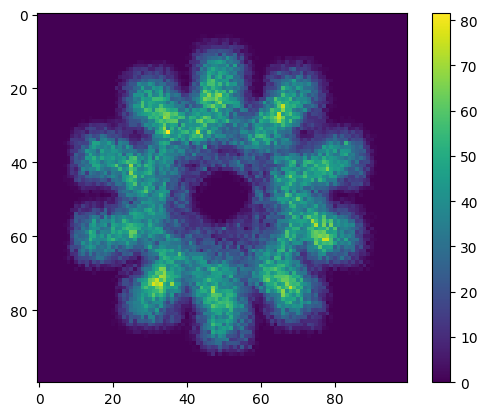

In [24]:
plt.imshow(result)
plt.colorbar()